In [1]:
# Imports and boilerplate to make graphs look better

%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np
import scipy
import wave
from IPython.display import Audio

def cpfsk_modulate(bit_str, bit_freq_map, baud, sample_rate):
    seconds_per_bit = 1 / baud
    samples_per_bit = int(sample_rate * seconds_per_bit)
    t = np.linspace(0, seconds_per_bit, samples_per_bit)
    
    # maps from bit sequence (like "10") to the modulated wave representing that "symbol"
    symbol_map = {bit_seq: np.sin(freq * 2 * np.pi * t) for bit_seq, freq in bit_freq_map.items()}

    signal = np.array([])
    bits_per_symbol = len(list(bit_freq_map.keys())[0])  # Assume all keys are the same length
    for symbol in [bit_str[i:i+bits_per_symbol] for i in range(0, len(bit_str), bits_per_symbol)]:
        symbol_wave = symbol_map[symbol]
        signal = np.append(signal, symbol_wave)
    return signal

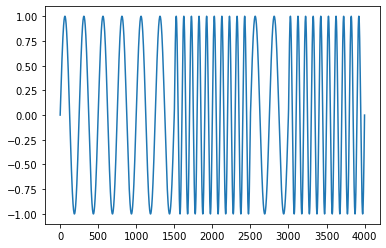

In [2]:
bit_freq_map = {
    "0": 2,
    "1": 5,
}

sig_mod = cpfsk_modulate("00011011", bit_freq_map, 1, 500)

#setup_graph(title='fsk-modulated "00011011"', fig_size=(18,5))
plt.plot(sig_mod)
plt.margins(0.05)

In [3]:
from numpy import sum,isrealobj,sqrt
from numpy.random import standard_normal

def awgn(s,SNRdB,L=1):
    """
    AWGN channel

    Add AWGN noise to input signal. The function adds AWGN noise vector to signal
    's' to generate a resulting signal vector 'r' of specified SNR in dB. It also
    returns the noise vector 'n' that is added to the signal 's' and the power
    spectral density N0 of noise added

    Parameters:
        s : input/transmitted signal vector
        SNRdB : desired signal to noise ratio (expressed in dB)
            for the received signal
        L : oversampling factor (applicable for waveform simulation)
            default L = 1.
    Returns:
        r : received signal vector (r=s+n)
    """
    gamma = 10**(SNRdB/10) #SNR to linear scale
    
    if s.ndim==1:# if s is single dimensional vector
        P=L*sum(abs(s)**2)/len(s) #Actual power in the vector
    else: # multi-dimensional signals like MFSK
        P=L*sum(sum(abs(s)**2))/len(s) # if s is a matrix [MxN]

    N0=P/gamma # Find the noise spectral density
    if isrealobj(s):# check if input is real/complex object type
        n = sqrt(N0/2)*standard_normal(s.shape) # computed noise
    else:
        n = sqrt(N0/2)*(standard_normal(s.shape)+1j*standard_normal(s.shape))
    r = s + n # received signal
    return r

In [4]:
def cpfsk_demodulate(raw_signal, bit_freq_map, baud, sample_rate):
    seconds_per_bit = 1 / baud
    samples_per_bit = int(sample_rate * seconds_per_bit)
    t = np.linspace(0, seconds_per_bit, samples_per_bit)
    
    # maps from bit sequence (like "10") to the modulated wave representing that "symbol"
    wave_to_symbol_map = {bit_seq: np.sin(freq * 2 * np.pi * t) for bit_seq, freq in bit_freq_map.items()}
    
    bit_str = ""
    for index in range(0, len(raw_signal), samples_per_bit):
        best_symbol = ""
        highest_dot_abs = 0
        for symbol, symbol_wave in wave_to_symbol_map.items():
            raw_window = raw_signal[index:index+samples_per_bit]
            dot_abs = np.abs(np.dot(symbol_wave[0:len(raw_window)], raw_window))
            if dot_abs > highest_dot_abs:
                best_symbol = symbol
                highest_dot_abs = dot_abs
        bit_str += best_symbol
    return bit_str

In [8]:
r = awgn(sig_mod,EbN0) # canal awgn
demodulated_aprs_msg = cpfsk_demodulate(r, bit_freq_map, 1, 500)
demodulated_aprs_msg

NameError: name 'EbN0' is not defined